In [64]:
import numpy as np
import matplotlib.pyplot as plt

In [65]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [66]:
from torchvision import datasets, models, transforms
from utils import view_data
from typing import List, Tuple

In [67]:
from easydict import EasyDict as edict
import pickle

In [68]:
from utils import view_data

In [69]:
args = edict({})
args.image_size = 240
args.batch_size = 25
args.log_interval = 100

In [70]:
# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset



In [71]:
transform_base =  transforms.Compose([
            transforms.Resize((int(args.image_size), int(args.image_size))),
            transforms.ToTensor(),  # Convert the image to pyTorch Tensor data type.
            transforms_norm, ])      
    

In [72]:
#path = '/run/user/1001/gvfs/dav:host=spik.xyz,ssl=true,prefix=%2Fnc%2Fremote.php%2Fdav/files/emmanuel/JNJER_PhD/'
#path = "/envau/work/brainets/dauce.e/data/animal/"
path = "/media/manu/Seagate Expansion Drive/"
path="/home/dauce/tmp/ap-10k-test/"
#path = "/run/user/1001/gvfs/sftp:host=bag-008-de03/envau/work/brainets/dauce.e/data/ap-10k/" #animal/"
#path = "../data/animal/"
#image_path = "Data/Imagenet/"
image_path = '' 


image_dataset = { 'test' : datasets.ImageFolder(
                            path+image_path+'data',
                            transform=transform_base
                        ),
                }

In [73]:
import json
fname = "imagenet-simple-labels.json"

with open(fname,'r') as f:
    class_labels = json.load(f)
    
print(class_labels)


['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'American robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'American dipper', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'agama', 'frilled-necked lizard', 'alligator lizard', 'Gila monster', 'European green lizard', 'chameleon', 'Komodo dragon', 'Nile crocodile', 'American alligator', 'triceratops', 'worm snake', 'ring-necked snake', 'eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'African rock p

In [74]:
num_workers = 1

dataloader = { 
               'test' : torch.utils.data.DataLoader(
                            image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [75]:
data, label = next(iter(dataloader['test']))

In [76]:
data.shape

torch.Size([25, 3, 240, 240])

In [77]:
def img_denorm(img, mean, std):
    #for ImageNet the mean and std are:
    #mean = np.asarray([ 0.485, 0.456, 0.406 ])
    #std = np.asarray([ 0.229, 0.224, 0.225 ])

    denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))

    res = img.squeeze(0)
    res = denormalize(res)

    #Image needs to be clipped since the denormalize function will map some
    #values below 0 and above 1
    res = torch.clamp(res, 0, 1)
    
    return(res)

In [78]:
from scipy.ndimage import map_coordinates
import math

def donut_LogPolar_Linear(img, a, b, o=None, r=None, output=None, order=1, cont=0, verb=False):
    # Take a < b < 0 : "donut" image between r = 2**a and r = 2**b < 1
    if r is None: r = img.shape[0]//2
    img_width = img.shape[0]
    r_ref = img.shape[0]//2
    if output is None:
        output = np.zeros((r*2, r*2, 3), dtype=img.dtype)
    elif isinstance(output, tuple):
        output = np.zeros(output, dtype=img.dtype)
    if o is None: o = np.array(output.shape[:2])/2 - 0.5
    out_h, out_w, col = output.shape
    ys, xs = np.mgrid[:out_h, :out_w] - o[:,None,None]    
    ys_n, xs_n = ys / r_ref, xs / r_ref
    rho = (ys_n**2+xs_n**2)**0.5
    rs =  (-np.log(2**a) + np.log(rho * 2**b)) / (np.log(2**b) - np.log(2**a)) * img_width
    if verb:
        print(r, np.min(rs), np.max(rs))
        plt.figure()
        _ = plt.hist(np.unique(rs),30)
    rho_ref = (ys**2+xs**2)**0.5
    ts = np.arccos(xs/rho_ref)
    ts[ys<0] = np.pi*2 - ts[ys<0]
    ts *= (img.shape[1]-1)/(np.pi*2)
    if verb:
        plt.figure()
        plt.imshow(rs)
        plt.imshow(rs<0, alpha=.3)
        plt.colorbar()
        plt.figure()
        plt.imshow(ts)
        plt.colorbar()
    for c in range(col):
        map_coordinates(img[:,:,c], (rs, ts), order=order, output=output[:,:,c])
        output[math.floor(o[0]),math.floor(o[1]),c] = img[0,img.shape[0]//2,c]
        output[math.floor(o[0]),math.ceil(o[1]),c] = img[0,img.shape[0]//2,c]
        output[math.ceil(o[0]),math.floor(o[1]),c] = img[0,img.shape[0]//2,c]
        output[math.ceil(o[0]),math.ceil(o[1]),c] = img[0,img.shape[0]//2,c]
    return output

In [79]:
def expand_dim(tensor, dim, desired_dim_len):
    sz = list(tensor.size())
    sz[dim]=desired_dim_len
    return tensor.expand(tuple(sz))

In [80]:
def logPolarGrid(a, b, base=2):
    rs = torch.logspace(a, b, args.image_size, base = base)
    ts = torch.linspace(0, torch.pi*2, args.image_size)
    
    grid_xs = torch.outer(rs, torch.cos(ts)) 
    grid_xs = grid_xs.unsqueeze(0).unsqueeze(3)
    grid_xs = Variable(grid_xs, requires_grad=False)

    grid_ys = torch.outer(rs, torch.sin(ts)) 
    grid_ys = grid_ys.unsqueeze(0).unsqueeze(3)
    grid_ys = Variable(grid_ys,  requires_grad=False)
    
    grid = torch.cat((grid_xs, grid_ys), 3)
    grid = expand_dim(grid, 0, args.batch_size)
    
    return grid.to(device) 

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
what_params = [0, -5]
what_grid = logPolarGrid(what_params[0], what_params[1]) 

In [83]:
path = 'out/'
f_load_init = f"resnet_polar_1000"
save_path = ''


In [84]:
saved_params_init = torch.load(path+f_load_init+'.pt', map_location=device)
resnet = models.resnet101(pretrained=True)
resnet.load_state_dict(saved_params_init, strict=False)  
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [85]:
#saved_params_init = torch.load(path+f_load_init+'.pt', map_location=device)

#resnet = models.resnet101(pretrained=True)
#resnet.load_state_dict(saved_params_init, strict=False)    

#resnet = resnet.to(device)

In [86]:
n_samples = 1
data, data_aff, target, logPolx, cat = [[]]*n_samples, [[]]*n_samples, [[]]*n_samples, [[]]*n_samples, [[]]*n_samples
center = args.image_size / 2 - 0.5 #np.array([a, args.image_size/2-0.5])
h_width = args.image_size / 2

for i in range(n_samples):
    data[i], target[i] = next(iter(dataloader['test']))
    with torch.no_grad():
        logPolx[i] = F.grid_sample(data[i].to(device), what_grid)
        y = resnet(logPolx[i])
    cat[i] = torch.argmax(y,1)
    data_aff[i] = [[]] * args.batch_size
    for j in range(len(data[i])):
        data_aff[i][j] = img_denorm(data[i][j], v_mean, v_std)

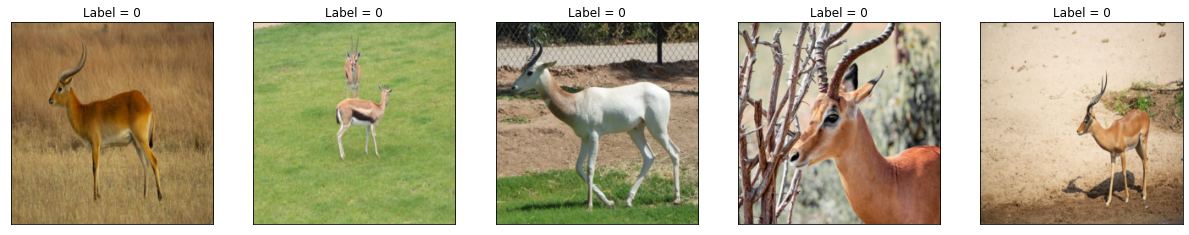

In [87]:
_ = view_data(img_denorm(data[0], v_mean, v_std), label, 5)

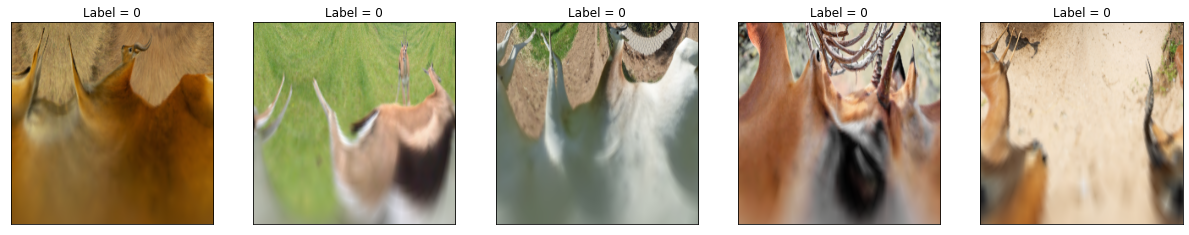

In [88]:

_ = view_data(img_denorm(logPolx[0], v_mean, v_std), label, 5)

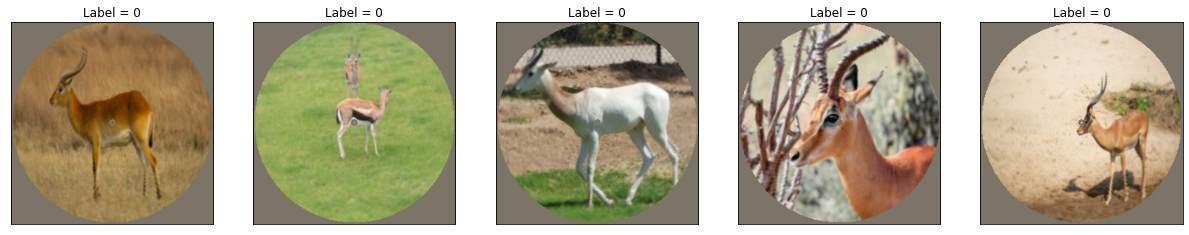

In [89]:
donut_data_rec = torch.zeros_like(logPolx[0])
for i in range(len(logPolx[0])):
    img = logPolx[0][i].permute(1,2,0).detach().numpy()
    if  what_params[0] < what_params[1]:
        img = donut_LogPolar_Linear(img, what_params[0], what_params[1], r=120, output=(240,240,3))
    else:
        img = donut_LogPolar_Linear(np.flipud(img), what_params[1], what_params[0], r=120, output=(240,240,3))
    #img = logpolar_linear(img, -4, 0, r=60, output=(240,240,3), verb=(i==0))
    donut_data_rec[i] = torch.FloatTensor(img).permute(2,0,1)
reconstructed = view_data(img_denorm(donut_data_rec, v_mean, v_std), label, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


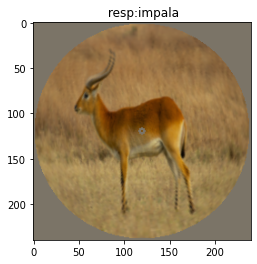

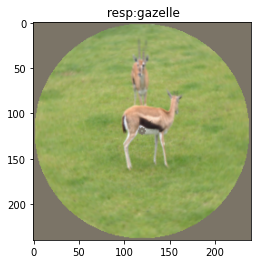

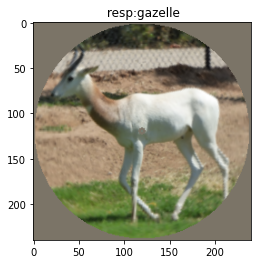

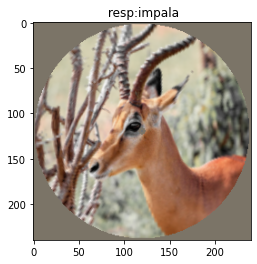

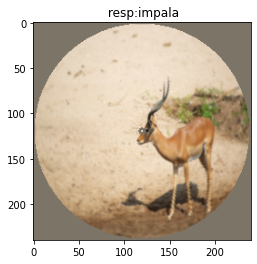

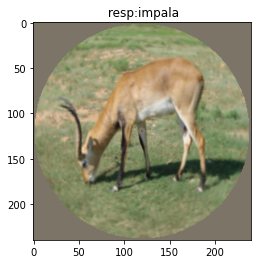

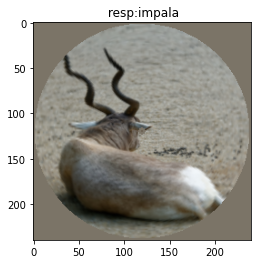

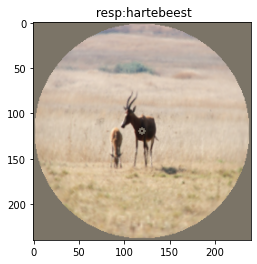

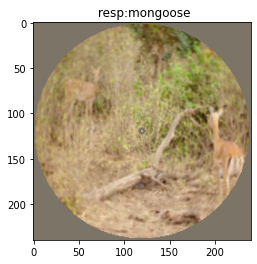

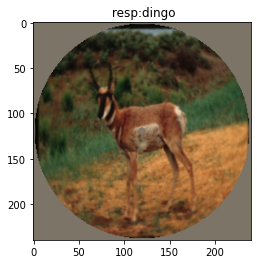

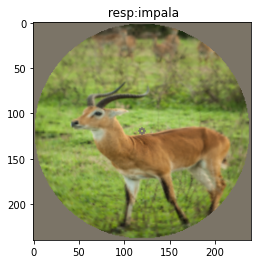

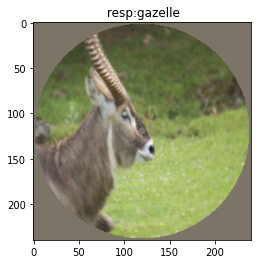

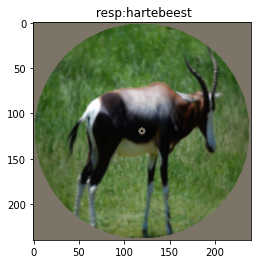

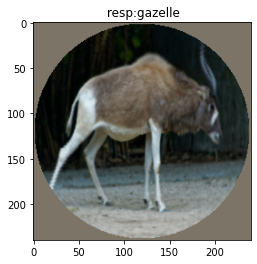

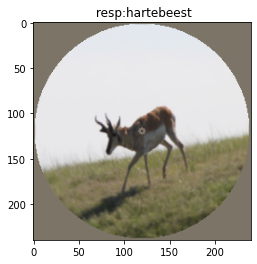

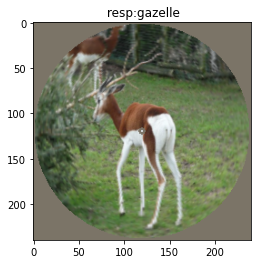

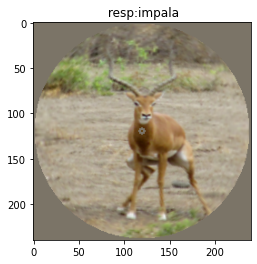

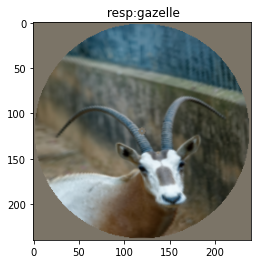

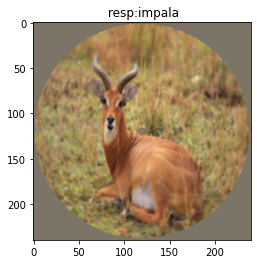

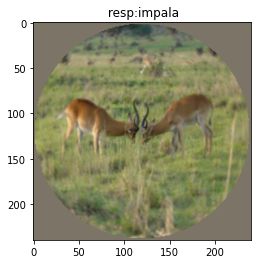

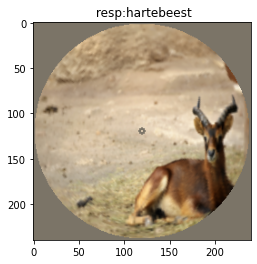

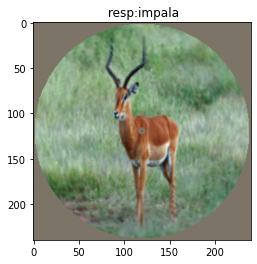

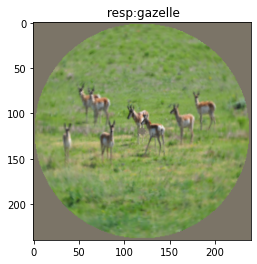

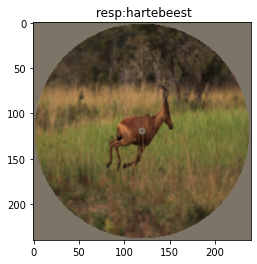

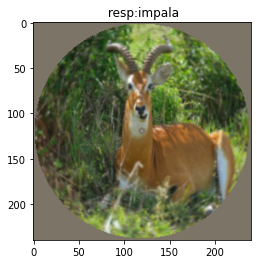

In [90]:
for i in range(n_samples):
    for num in range(args.batch_size):
        plt.figure()
        img = logPolx[i][num].permute(1,2,0).detach().numpy()
        if  what_params[0] < what_params[1]:
            img = donut_LogPolar_Linear(img, what_params[0], what_params[1], r=120, output=(240,240,3))
        else:
            img = donut_LogPolar_Linear(np.flipud(img), what_params[1], what_params[0], r=120, output=(240,240,3))
        img = torch.FloatTensor(img).permute(2,0,1).unsqueeze(0)
        plt.imshow(img_denorm(img, v_mean, v_std).permute(1,2,0).detach().numpy())
        #plt.title('true:'+class_labels[target[i][num]]+' resp:'+class_labels[cat[i][num]])
        plt.title(' resp:'+class_labels[cat[i][num]])
       